# Improved SCA based on SVM
---

In this notebook, we will utilize the trained model to predict the Hamming weight of the intermediate value and deduce the specific byte of the encryption key.


`Note:` This is the Hamming Weight attack, make sure you've trained a HW model or use the included one.

---

#### 1. Importing attack traces and model

In [1]:
import chipwhisperer as cw
import numpy as np

In [2]:
byte_index = 0
print(f'We are attacking byte {byte_index}')

We are attacking byte 0


In [15]:
import joblib

# To use the included Traces
# project_file = 'SCA_SVM_DATA/Included/traces/attack_traces.cwp'

project_folder = 'SCA_SVM_DATA'    
traces_folder = f'{project_folder}/traces'
project_file = f'{traces_folder}/attack_traces.cwp'

project = cw.open_project(project_file)
traces = np.array(project.waves)
textins = project.textins
textouts = project.textouts
unknown_key = project.keys[0][byte_index]
hex_unknown_key = hex(unknown_key)

print(f'✅ Loaded {len(traces)} traces, textins, ciphertexts with the unknown key {hex_unknown_key}')

✅ Loaded 10000 traces, textins, ciphertexts with the unknown key 0xf4


In [16]:
# To use the included model
# model_file = 'SCA_SVM_DATA/Included/models/hw_model.pkl'

model_file = f'{project_folder}/models/hw_model.pkl'

model_data = joblib.load(model_file)
model = model_data['model']
p = model_data['p']

print(f'✅ Loaded the attack model')

✅ Loaded the attack model


#### 2. Attacking the S-Box
Since we perform a profiled attack, the S-box remains unchanged across devices.

We apply the same preprocessing as in the training phase to obtain a prediction, which represents the Hamming weight of the S-box output.

Knowing the plaintext and the S-box contents, we iterate over all possible keys, checking which ones produce an intermediate value with the predicted Hamming weight.

The key that appears most frequently is likely the correct one.

In [8]:
SBOX = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

In [9]:
def hamming_weight(value):
    return bin(value).count('1')

In [10]:
def get_k_counters(T):
    t = traces[:T].T
    X = t[np.sort(p)].T
    predictions = model.predict(X)
    
    k_counters = np.zeros(256, dtype=int)
    for i,c in enumerate(predictions):
        for k in range(256):
            s = SBOX[textins[i][0]^k]
            hw = hamming_weight(s)
            if hw == c:
                k_counters[k]+=1
    return k_counters

In [32]:
def attack(T=4):
    k_counters = get_k_counters(T)
    max_value = np.max(k_counters)
    max_indices = np.where(k_counters == max_value)[0]
    keys = [hex(i) for i in max_indices]
    print(f'#Traces={T}: {len(keys)} possible keys: {keys}')

In [33]:
for i in range(1,10):
    attack(i)

#Traces=1: 56 possible keys: ['0x4', '0xa', '0x10', '0x13', '0x14', '0x16', '0x17', '0x18', '0x24', '0x25', '0x27', '0x28', '0x2e', '0x45', '0x52', '0x53', '0x57', '0x58', '0x59', '0x5c', '0x62', '0x6c', '0x76', '0x77', '0x82', '0x86', '0x87', '0x8c', '0x8f', '0x96', '0x9d', '0xa8', '0xb1', '0xb5', '0xb6', '0xb8', '0xbc', '0xc0', '0xce', '0xcf', '0xd0', '0xd2', '0xd4', '0xd6', '0xd8', '0xdd', '0xde', '0xe0', '0xe3', '0xe6', '0xe7', '0xe8', '0xee', '0xef', '0xf2', '0xf4']
#Traces=2: 12 possible keys: ['0x57', '0x5c', '0x62', '0x6c', '0xbc', '0xce', '0xcf', '0xd0', '0xd2', '0xe3', '0xe7', '0xf4']
#Traces=3: 3 possible keys: ['0xcf', '0xd2', '0xf4']
#Traces=4: 1 possible keys: ['0xf4']
#Traces=5: 1 possible keys: ['0xf4']
#Traces=6: 1 possible keys: ['0xf4']
#Traces=7: 1 possible keys: ['0xf4']
#Traces=8: 1 possible keys: ['0xf4']
#Traces=9: 1 possible keys: ['0xf4']


### 🎉 Success!
After just 4 traces, the correct key is the only remaining possibility!  

Now, let's visualize it:

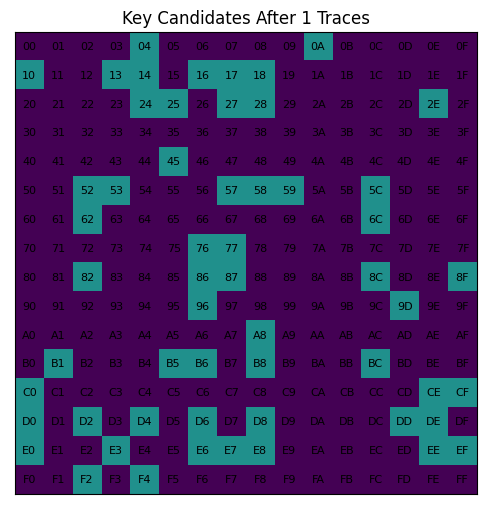

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as animation
from IPython.display import Video


# Function to generate a key probability heatmap
def visualize_key_heatmap(ax, k_counters, T):
    ax.clear()
    
    # Reshape to 16x16 grid
    key_grid = k_counters.reshape((16, 16))
    
    # Create heatmap
    cmap = plt.cm.viridis
    norm = mcolors.Normalize(vmin=0, vmax=np.max(k_counters) + 1)
    
    im = ax.imshow(key_grid, cmap=cmap, norm=norm)

    # Add key labels
    for i in range(16):
        for j in range(16):
            key_hex = f"{i*16 + j:02X}"
            ax.text(j, i, key_hex, ha="center", va="center", fontsize=8, color="black")
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Key Candidates After {T} Traces")

    return im

# Function to create animation
def generate_mp4():
    fig, ax = plt.subplots(figsize=(6,6))

    def update(T):
        k_counters = get_k_counters(T)
        return visualize_key_heatmap(ax, k_counters, T)
    
    ani = animation.FuncAnimation(fig, update, frames=range(1, 21), interval=200, blit=False)
    
    # Save as MP4
    video_path = 'SCA_SVM_DATA/HW_key_recovery.mp4'
    ani.save(video_path, writer="ffmpeg", fps=3)
    
    return video_path

# Generate and save the MP4
video_path = generate_mp4()
Video(video_path, embed=True)